Hãy sử dụng dữ liệu được cung cấp trong email này (dữ liệu giá và khối
lượng của một vài mã cổ phiếu) để xây dựng một số mô hình dự đoán biến
động giá cổ phiếu.

Biến động giá cổ phiếu = Giá cổ phiếu N (phút hoặc giờ hoặc ngày) sau - Giá cổ phiếu hiện tại.

In [1]:
!pip uninstall tensorflow # Fill Y to install latest tf and keras
!pip install tensorflow

Found existing installation: tensorflow 2.15.0
Uninstalling tensorflow-2.15.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.10/dist-packages/tensorflow-2.15.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/tensorflow/*
Proceed (Y/n)? Y
  Successfully uninstalled tensorflow-2.15.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 89.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 84.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 85.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 66.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# I. XỬ LÝ THEO NGÀY
Ý tưởng: Sử dụng dữ liệu Δ 60 ngày trước đó (X_train) để dự đoán Δ 20 ngày tiếp theo (Y_train) (N_max = 20)

In [4]:
# Tương tự thay đổi tên cho các mã khác
csv_dir = "PNJ.csv"
save_model_dir = "PNJ_day.keras"

## 1. Import dữ liệu và xử lý Pandas

In [5]:
df = pd.read_csv(csv_dir)
df.head(10)

,Ticker,Date/Time,Open,High,Low,Close,Volume,Open Interest
0,PNJ,2/28/2018 9:15,78.14,78.99,78.14,78.99,270,0
1,PNJ,2/28/2018 9:16,78.94,78.94,78.94,78.94,10,0
2,PNJ,2/28/2018 9:19,78.14,78.14,78.14,78.14,283,0
3,PNJ,2/28/2018 9:20,78.14,78.14,78.14,78.14,480,0
4,PNJ,2/28/2018 9:21,78.14,78.14,78.14,78.14,146,0
5,PNJ,2/28/2018 9:22,78.09,78.09,78.09,78.09,100,0
6,PNJ,2/28/2018 9:23,78.09,78.14,78.09,78.14,210,0
7,PNJ,2/28/2018 9:24,78.14,78.14,78.14,78.14,32,0
8,PNJ,2/28/2018 9:25,78.75,78.75,78.75,78.75,20,0
9,PNJ,2/28/2018 9:26,78.75,78.75,78.75,78.75,50,0


***Nhận thấy cột ngày là object***

Ta dùng pandas để chuyển nó thành date time thực sự

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125309 entries, 0 to 125308
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Ticker         125309 non-null  object 
 1   Date/Time      125309 non-null  object 
 2   Open           125309 non-null  float64
 3   High           125309 non-null  float64
 4   Low            125309 non-null  float64
 5   Close          125309 non-null  float64
 6   Volume         125309 non-null  int64  
 7   Open Interest  125309 non-null  int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 7.6+ MB


In [7]:
df["Date/Time"] = pd.to_datetime(df["Date/Time"])
df.head()

,Ticker,Date/Time,Open,High,Low,Close,Volume,Open Interest
0,PNJ,2018-02-28 09:15:00,78.14,78.99,78.14,78.99,270,0
1,PNJ,2018-02-28 09:16:00,78.94,78.94,78.94,78.94,10,0
2,PNJ,2018-02-28 09:19:00,78.14,78.14,78.14,78.14,283,0
3,PNJ,2018-02-28 09:20:00,78.14,78.14,78.14,78.14,480,0
4,PNJ,2018-02-28 09:21:00,78.14,78.14,78.14,78.14,146,0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125309 entries, 0 to 125308
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Ticker         125309 non-null  object        
 1   Date/Time      125309 non-null  datetime64[ns]
 2   Open           125309 non-null  float64       
 3   High           125309 non-null  float64       
 4   Low            125309 non-null  float64       
 5   Close          125309 non-null  float64       
 6   Volume         125309 non-null  int64         
 7   Open Interest  125309 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(2), object(1)
memory usage: 7.6+ MB


***Trích xuất theo ngày***

Ta gộp các bản ghi trong một ngày lại với nhau. Giá cổ phiếu ứng với ngày đó sẽ là giá đóng cửa của bản ghi cuối cùng.


In [9]:
# Tạo cột date
df["Date"] = df["Date/Time"].dt.date
df.head()

,Ticker,Date/Time,Open,High,Low,Close,Volume,Open Interest,Date
0,PNJ,2018-02-28 09:15:00,78.14,78.99,78.14,78.99,270,0,2018-02-28
1,PNJ,2018-02-28 09:16:00,78.94,78.94,78.94,78.94,10,0,2018-02-28
2,PNJ,2018-02-28 09:19:00,78.14,78.14,78.14,78.14,283,0,2018-02-28
3,PNJ,2018-02-28 09:20:00,78.14,78.14,78.14,78.14,480,0,2018-02-28
4,PNJ,2018-02-28 09:21:00,78.14,78.14,78.14,78.14,146,0,2018-02-28


In [10]:
daily_df = df.groupby("Date").apply(lambda x: x.iloc[-1]).reset_index(drop=True)
daily_df.head(10)

,Ticker,Date/Time,Open,High,Low,Close,Volume,Open Interest,Date
0,PNJ,2018-02-28 11:26:00,78.71,78.71,78.71,78.71,41,0,2018-02-28
1,PNJ,2018-03-01 14:46:00,77.66,77.66,77.66,77.66,2822,0,2018-03-01
2,PNJ,2018-03-02 14:46:00,77.33,77.33,77.33,77.33,1421,0,2018-03-02
3,PNJ,2018-03-05 14:46:00,78.28,78.28,78.28,78.28,1224,0,2018-03-05
4,PNJ,2018-03-06 14:46:00,81.45,81.45,81.45,81.45,2540,0,2018-03-06
5,PNJ,2018-03-07 14:46:00,80.74,80.74,80.74,80.74,439,0,2018-03-07
6,PNJ,2018-03-08 14:46:00,82.35,82.35,82.35,82.35,889,0,2018-03-08
7,PNJ,2018-03-09 14:46:00,82.35,82.35,82.35,82.35,383,0,2018-03-09
8,PNJ,2018-03-12 14:46:00,81.78,81.78,81.78,81.78,788,0,2018-03-12
9,PNJ,2018-03-13 14:46:00,81.12,81.12,81.12,81.12,739,0,2018-03-13


In [11]:
useDf = pd.DataFrame(daily_df, columns=['Close', 'Date'])
useDf.index = useDf["Date"]
useDf = useDf.drop(columns=["Date"])
useDf

,Close
Date,
2018-02-28,78.71
2018-03-01,77.66
2018-03-02,77.33
2018-03-05,78.28
2018-03-06,81.45
...,...
2020-12-16,77.60
2020-12-17,75.80
2020-12-18,77.30


## 2. Trích chọn đặc trưng với NumPy


In [12]:
data = useDf.values  # lấy giá trị từ series (cột)
data

array([[78.71],
       [77.66],
       [77.33],
       [78.28],
       [81.45],
       [80.74],
       [82.35],
       [82.35],
       [81.78],
       [81.12],
       [81.64],
       [81.45],
       [85.24],
       [86.38],
       [86.19],
       [86.66],
       [87.13],
       [85.71],
       [87.75],
       [91.21],
       [93.29],
       [93.76],
       [97.55],
       [98.9 ],
       [95.9 ],
       [95.37],
       [94.95],
       [91.87],
       [87.61],
       [91.4 ],
       [88.56],
       [88.22],
       [88.08],
       [87.47],
       [85.95],
       [84.68],
       [78.14],
       [81.64],
       [82.4 ],
       [82.4 ],
       [80.81],
       [80.98],
       [80.98],
       [82.26],
       [80.98],
       [86.61],
       [86.71],
       [86.42],
       [83.82],
       [86.66],
       [88.18],
       [87.7 ],
       [86.28],
       [85.81],
       [85.81],
       [85.33],
       [83.86],
       [84.86],
       [84.86],
       [82.49],
       [78.42],
       [78.22],
       [

In [13]:
scaler = MinMaxScaler(feature_range=(0,1))
data = scaler.fit_transform(data)

In [14]:
train_data = data[:-100]
test_data = data[-100:]

In [16]:
train_interval = 60 # two months ago
predict_interval = 20 # 20 days next

X_train, Y_train = [], []

for i in range(train_interval, len(train_data)):
    base_X = train_data[i, 0]
    X_train.append(np.array(data[i - train_interval : i]) - base_X)
    Y_train.append(np.array(data[i : i + predict_interval]) - base_X)

X_train = np.array(X_train)
Y_train = np.array(Y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
Y_train = np.reshape(Y_train, (Y_train.shape[0], Y_train.shape[1]))

print("Shape of X_train:", X_train.shape)  # Expected: (number_of_samples, 60, 1)
print("Shape of Y_train:", Y_train.shape)  # Expected: (number_of_samples, 20)

Shape of X_train: (549, 60, 1)
Shape of Y_train: (549, 20)


## 3. Xây dựng mô hình

In [17]:
from keras.models import Sequential, load_model
from keras.layers import Input, Dense, LSTM, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [18]:
model = Sequential([
    Input(shape=(train_interval,1)),
    LSTM(units=256, return_sequences=True),
    Dropout(0.3),
    LSTM(units=128),
    Dropout(0.5),
    Dense(predict_interval)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_absolute_error')
# Huấn luyện mô hình
selBest = ModelCheckpoint(save_model_dir, monitor='loss', save_best_only=True, mode='auto')
history = model.fit(X_train, Y_train, epochs=500, batch_size=32, validation_split=0.1, callbacks=[selBest])

Epoch 1/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 425ms/step - loss: 0.0668 - val_loss: 0.0519
Epoch 2/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 289ms/step - loss: 0.0642 - val_loss: 0.0553
Epoch 3/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 396ms/step - loss: 0.0640 - val_loss: 0.0505
Epoch 4/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 293ms/step - loss: 0.0662 - val_loss: 0.0496
Epoch 5/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 381ms/step - loss: 0.0659 - val_loss: 0.0563
Epoch 6/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 321ms/step - loss: 0.0646 - val_loss: 0.0523
Epoch 7/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 281ms/step - loss: 0.0668 - val_loss: 0.0496
Epoch 8/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 431ms/step - loss: 0.0644 - val_loss: 0.0497
Epoch 9/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 282ms/step - loss: 0.0674 - val_loss: 0.0509
Epoch 10/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 398ms/step - loss: 0.0646 - val_loss: 0.0542
Epoch 11/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 290ms/step - loss: 0.0634 - val_loss: 0.0490
Epoch 12/500
16/16 ━━━━━━━━━━━━━━━━━━━━

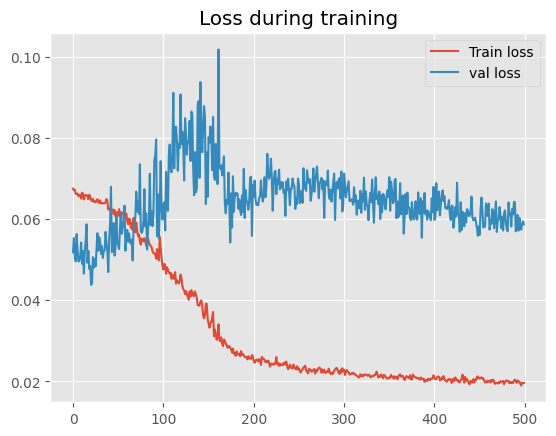

In [19]:
plt.style.use('ggplot')
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title('Loss during training')
plt.show()

In [20]:
model = load_model(save_model_dir)

In [21]:
Y_1_predict = model.predict(X_train)
Y_1_predict.shape

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step


(549, 20)

In [23]:
Y_1_predict = model.predict(X_train)
Y_1_predict.shape

18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step


(549, 20)

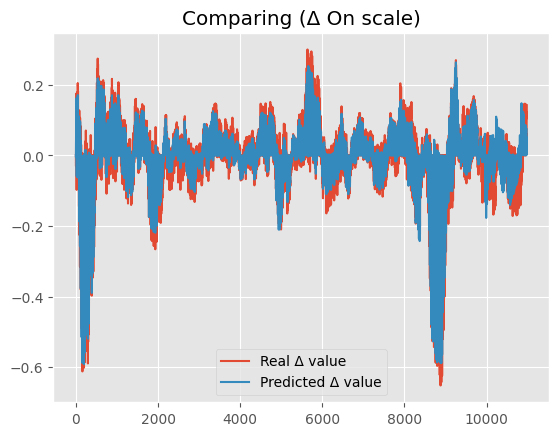

In [24]:
plt.style.use('ggplot')
plt.plot(Y_train.flatten(), label='Real Δ value')
plt.plot(Y_1_predict.flatten(), label='Predicted Δ value')
plt.legend()
plt.title('Comparing (Δ On scale)')
plt.show()

## 4. Tập kiểm thử

In [29]:
test_interval = 60 # two months = train_interval
predict_interval = 20 # 20 days next

X_test, Y_test = [], []
data_len = len(train_data)

for i in range(0, len(test_data) - predict_interval):
    base_X = test_data[i, 0]
    j = data_len + i
    X_test.append(np.array(data[j - test_interval : j]) - base_X)
    Y_test.append(np.array(data[j : j + predict_interval]) - base_X)

X_test = np.array(X_test)
Y_test = np.array(Y_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
Y_test = np.reshape(Y_test, (Y_test.shape[0], Y_test.shape[1]))

print("Shape of X_test:", X_test.shape)  # Expected: (number_of_samples, 60, 1)
print("Shape of Y_test:", Y_test.shape)  # Expected: (number_of_samples, 20)

Shape of X_train: (80, 60, 1)
Shape of Y_train: (80, 20)


In [30]:
model = load_model(save_model_dir)

In [31]:
Y_test_predict = model.predict(X_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 209ms/step


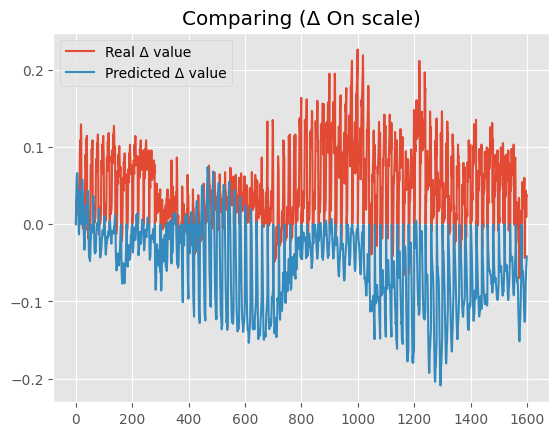

In [32]:
plt.style.use('ggplot')
plt.plot(Y_test.flatten(), label='Real Δ value')
plt.plot(Y_test_predict.flatten(), label='Predicted Δ value')
plt.legend()
plt.title('Comparing (Δ On scale)')
plt.show()